In [ ]:
import pandas as pd

In [ ]:
hyundai = pd.read_csv('/content/005380_hyundai.csv')
samsung = pd.read_csv('/content/005930_samsung.csv')
kepco = pd.read_csv('/content/015760_kepco.csv')

In [ ]:
samsung['date'] = samsung['date'].astype('str')
samsung['date'] = pd.to_datetime(samsung['date'])
samsung.index = samsung['date']
samsung.set_index('date', inplace=True)

In [ ]:
samsung_train_df = samsung[:971]
samsung_test_df = samsung[971:]

In [ ]:
samsung_test_df

,open,high,low,close,volume,per,pbr,roe,market_kospi_ma5_ratio,market_kospi_ma20_ratio,market_kospi_ma60_ratio,market_kospi_ma120_ratio,bond_k3y_ma5_ratio,bond_k3y_ma20_ratio,bond_k3y_ma60_ratio,bond_k3y_ma120_ratio
date,,,,,,,,,,,,,,,,
2019-12-23,56100.0,56400.0,55100.0,55500.0,9839252.0,9.04,1.15,13.42,0.997957,1.015010,1.002079,1.013144,1.000018,0.998755,0.997720,0.995154
2019-12-24,55600.0,55700.0,54800.0,55000.0,11868463.0,9.04,1.15,13.42,0.988089,1.002355,0.988296,1.000266,1.000299,0.999169,0.998123,0.995479
2019-12-26,54700.0,55400.0,54400.0,55400.0,9645034.0,9.04,1.15,13.42,1.007469,1.022626,1.007865,1.021415,1.000245,0.999267,0.998169,0.995454
2019-12-27,55700.0,56900.0,55500.0,56500.0,12313056.0,9.04,1.15,13.42,1.017427,1.035297,1.021272,1.036185,0.999973,0.999187,0.997981,0.995209
2019-12-30,56200.0,56600.0,55700.0,55800.0,8356767.0,9.04,1.15,13.42,1.024308,1.045730,1.033333,1.049980,1.000390,1.000034,0.998697,0.995862


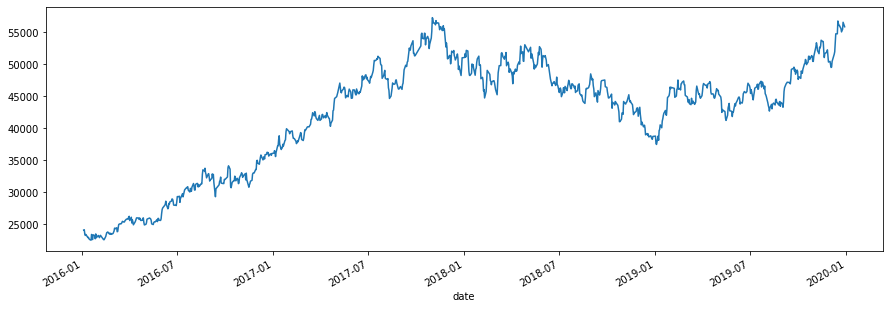

In [ ]:
samsung['close'].plot(figsize=(15,5))

### **ARIMA model**

ADF 검정으로 정상성 확인

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(samsung_train_df.close)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')

diff_1 = samsung_train_df.diff(periods=1).iloc[3]
result1 = adfuller(diff_1)
print(f'1차 차분 ADF Statistic: {result1[0]:.3f}')
print(f'1차 차분 p-value: {result1[1]:.3f}')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



원 데이터 ADF Statistic: -1.544
원 데이터 p-value: 0.512
1차 차분 ADF Statistic: -188.231
1차 차분 p-value: 0.000


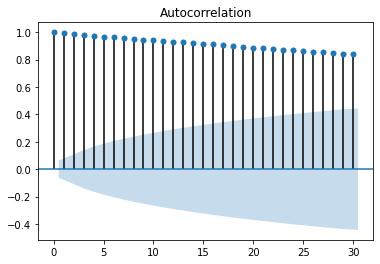

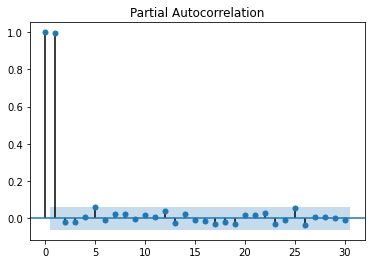

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(samsung_train_df.close)
plot_pacf(samsung_train_df.close)
plt.show()

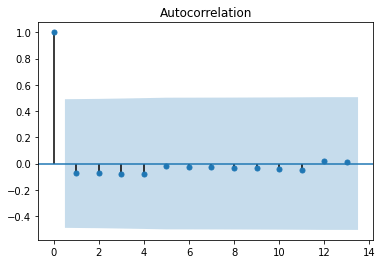

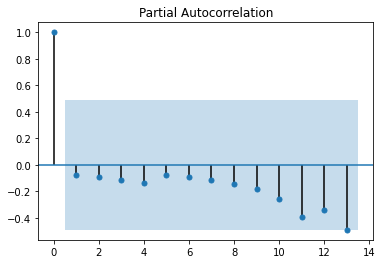

In [ ]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(samsung_train_df.close.values, order=(2,1,1))
model_fit = model.fit(trend='c',full_output=True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  970
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -7699.972
Method:                       css-mle   S.D. of innovations            678.008
Date:                Tue, 26 Oct 2021   AIC                          15409.943
Time:                        06:03:29   BIC                          15434.330
Sample:                             1   HQIC                         15419.225
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.4289     16.386      1.979      0.048       0.314      64.544
ar.L1.D.y      0.9458      0.094     10.081      0.000       0.762       1.130
ar.L2.D.y     -0.0527      0.034     -1.556      0.1

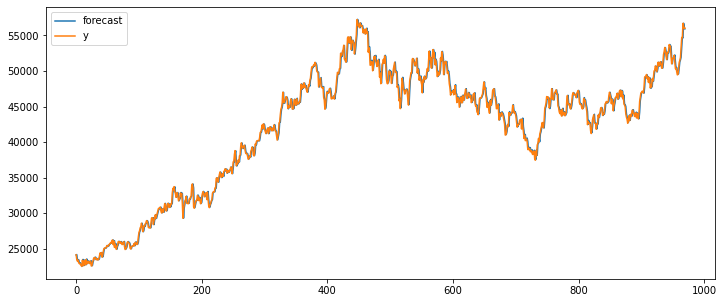

In [ ]:
# 학습한 ARIMA 모델에 학습 데이터를 넣어 예측한 결과
plt.rcParams["figure.figsize"] = (12,5)
fig = model_fit.plot_predict()

In [ ]:
forecast_data = model_fit.forecast(steps=5)
pred = forecast_data[0].tolist()
real = samsung_test_df.close.values

result_df = pd.DataFrame(pred, columns=['pred'])
result_df['real'] = real.reshape(-1)
result_df['diff'] = result_df['real'] - result_df['pred']
result_df

,pred,real,diff
0,55944.039782,55500.0,-444.039782
1,55894.582546,55000.0,-894.582546
2,55854.223187,55400.0,-454.223187
3,55822.125635,56500.0,677.874365
4,55797.362492,55800.0,2.637508


In [ ]:
pred_y_lower = []
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

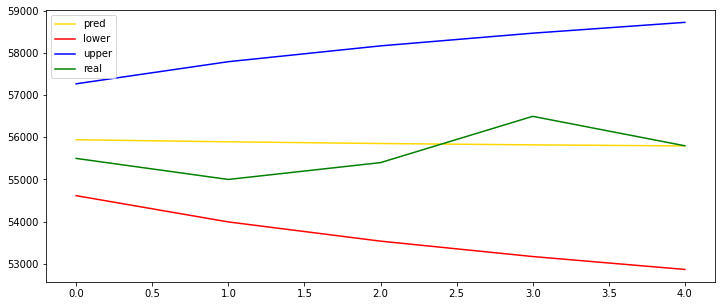

In [ ]:
plt.plot(pred, color = 'gold') #예측
plt.plot(pred_y_lower, color = 'red') #예측 하한가
plt.plot(pred_y_upper, color = 'blue') #예측 상한가
plt.plot(real, color = 'green') #실제
plt.legend(['pred', 'lower', 'upper', 'real'])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred, real))
print("ARIMA model RMSE: ", rmse)

ARIMA model RMSE:  576.764869635901


### **Facebook Prophet model (트렌드를 예측하는 것에 초점)**

선형회귀 분석의 단점을 극복하기 위한 Additive model

In [ ]:
from fbprophet import Prophet
samsung_df = pd.read_csv('/content/005930_samsung.csv')
samsung_df = samsung_df.loc[:, ['date', 'close']]
samsung_df['date'] = samsung_df['date'].astype('str')
samsung_df['date'] = pd.to_datetime(samsung_df['date'])
samsung_df.columns = ['ds', 'y']

,ds,y
0,2016-01-04,24100.0
1,2016-01-05,24160.0
2,2016-01-06,23500.0
3,2016-01-07,23260.0
4,2016-01-08,23420.0
...,...,...
971,2019-12-23,55500.0
972,2019-12-24,55000.0
973,2019-12-26,55400.0
974,2019-12-27,56500.0


In [ ]:
prophet_train = samsung_df[:971]

In [ ]:
prophet = Prophet(seasonality_mode = 'multiplicative', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, changepoint_prior_scale=0.5)
prophet.fit(prophet_train)

In [ ]:
future = prophet.make_future_dataframe(periods = 5)
forecast_data2 = prophet.predict(future)

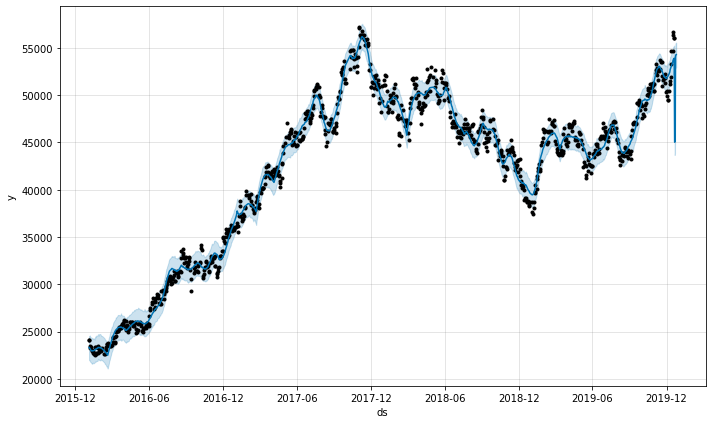

In [ ]:
fig1 = prophet.plot(forecast_data2)

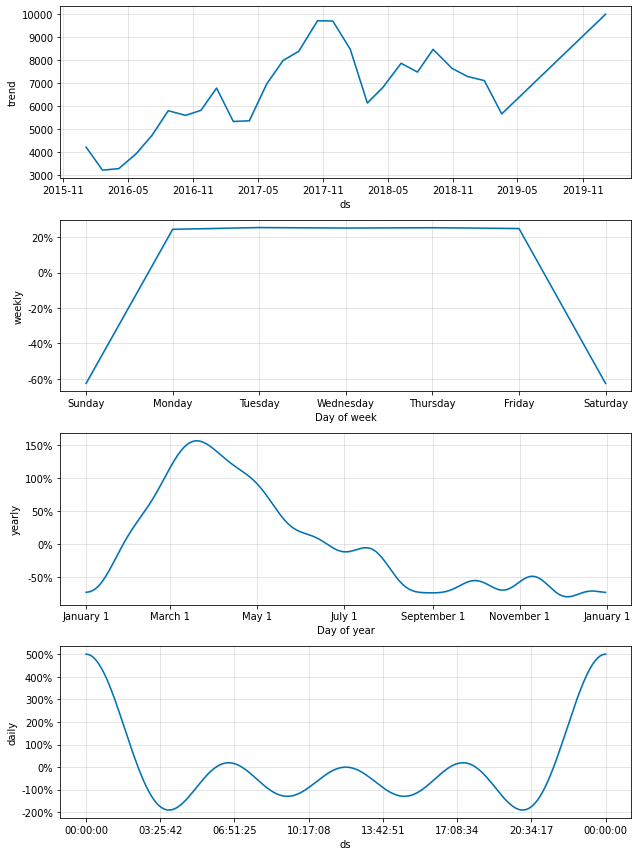

In [ ]:
#전체적인 트렌드와 weekly, yearly, daily
fig2 = prophet.plot_components(forecast_data2)

In [ ]:
forecast_data2.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
971,2019-12-21,9066.206167,43669.248247,46290.400678,9066.206167,9066.206167,5.653828,5.653828,5.653828,3.965684,3.965684,3.965684,-0.706729,-0.706729,-0.706729,-0.981416,-0.981416,-0.981416,0.0,0.0,0.0,45019.914447
972,2019-12-22,9080.677826,43816.390154,46473.289753,9080.677826,9080.677826,5.653828,5.653828,5.653828,3.964218,3.964218,3.964218,-0.706729,-0.706729,-0.706729,-0.982881,-0.982881,-0.982881,0.0,0.0,0.0,45078.465080
973,2019-12-23,9095.149484,52763.320522,55393.906336,9095.149484,9095.149484,5.653828,5.653828,5.653828,4.943120,4.943120,4.943120,0.274365,0.274365,0.274365,-0.985073,-0.985073,-0.985073,0.0,0.0,0.0,54053.568354
974,2019-12-24,9109.621143,52881.893684,55544.843517,9109.621143,9109.621143,5.653828,5.653828,5.653828,4.953530,4.953530,4.953530,0.287474,0.287474,0.287474,-0.987772,-0.987772,-0.987772,0.0,0.0,0.0,54234.402198
975,2019-12-25,9124.092801,52964.229226,55548.597407,9124.092801,9124.092801,5.653828,5.653828,5.653828,4.948640,4.948640,4.948640,0.285535,0.285535,0.285535,-0.990722,-0.990722,-0.990722,0.0,0.0,0.0,54275.947329


In [ ]:
pred2 = forecast_data2.yhat.values[-5:]
real2 = samsung_df.y.values[-5:]
pred_lower = forecast_data2.yhat_lower.values[-5:]
pred_upper = forecast_data2.yhat_upper.values[-5:]

result_df2 = pd.DataFrame(pred2, columns=['pred'])
result_df2['real'] = real2.reshape(-1)
result_df2['diff'] = result_df2['real'] - result_df2['pred']
result_df2

,pred,real,diff
0,45019.914447,55500.0,10480.085553
1,45078.465080,55000.0,9921.534920
2,54053.568354,55400.0,1346.431646
3,54234.402198,56500.0,2265.597802
4,54275.947329,55800.0,1524.052671


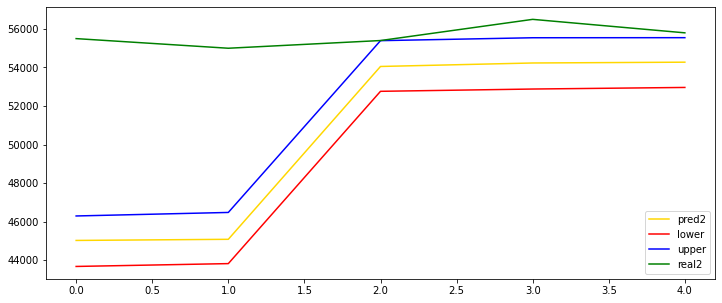

In [ ]:
plt.plot(pred2, color = 'gold') #예측
plt.plot(pred_lower, color = 'red') #예측 하한가
plt.plot(pred_upper, color = 'blue') #예측 상한가
plt.plot(real2, color = 'green') #실제
plt.legend(['pred2', 'lower', 'upper', 'real2'])

In [ ]:
rmse2 = sqrt(mean_squared_error(pred2, real2))
print("Facebook Prophet RMSE: ", rmse2)

Facebook Prophet RMSE:  6596.022991045459


### **주가 데이터 불러오기(LSTM)**

In [1]:
pip install finance-datareader

In [81]:
#우정바이오 215380 / 엑세스바이오 950130 / 삼성전자 005930 
import FinanceDataReader as fdr
samsung = fdr.DataReader('005930', '2010')
bio = fdr.DataReader('215380', '2010')
access_bio = fdr.DataReader('950130', '2010')

In [82]:
kospi = fdr.DataReader('KS11', '2010')
kospi.rename(columns={'Open' : 'KOSPI'}, inplace = True)

kosdaq = fdr.DataReader('KQ11', '2010')
kosdaq.rename(columns={'Open' : 'KOSDAQ'}, inplace = True)

nasdaq = fdr.DataReader('IXIC', '2010')
nasdaq.rename(columns={'Close' : 'NASDAQ'}, inplace = True)

kospi = kospi[['KOSPI']]
kosdaq = kosdaq[['KOSDAQ']]
nasdaq = nasdaq[['NASDAQ']]

In [83]:
#삼성전자
import pandas as pd
samsung_df = pd.merge(samsung, kosdaq, on = 'Date', how = 'right')
samsung_df = pd.merge(samsung_df, kospi, on = 'Date', how = 'right')
samsung_df = pd.merge(samsung_df, nasdaq, on = 'Date', how = 'right')

In [84]:
#우정바이오
import pandas as pd
bio_df = pd.merge(bio, kosdaq, on = 'Date', how = 'right')
bio_df = pd.merge(bio_df, kospi, on = 'Date', how = 'right')
bio_df = pd.merge(bio_df, nasdaq, on = 'Date', how = 'right')

In [85]:
#엑세스바이오
access_bio_df = pd.merge(access_bio, kosdaq, on = 'Date', how = 'right')
access_bio_df = pd.merge(access_bio_df, kospi, on = 'Date', how = 'right')
access_bio_df = pd.merge(access_bio_df, nasdaq, on = 'Date', how = 'right')

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

In [86]:
samsung_df = samsung_df.dropna(axis=0)
samsung_df.reset_index(inplace = True)
samsung_df

,Date,Open,High,Low,Close,Volume,Change,KOSDAQ,KOSPI,NASDAQ
0,2010-01-04,16060.0,16180.0,16000.0,16180.0,239271.0,0.012516,517.03,1681.71,2308.4
1,2010-01-05,16520.0,16580.0,16300.0,16440.0,559219.0,0.016069,533.43,1701.62,2308.7
2,2010-01-06,16580.0,16820.0,16520.0,16820.0,459755.0,0.023114,537.10,1697.88,2301.1
3,2010-01-07,16820.0,16820.0,16260.0,16260.0,443237.0,-0.033294,542.88,1702.92,2300.1
4,2010-01-08,16400.0,16420.0,16120.0,16420.0,295798.0,0.009840,539.63,1694.06,2317.2
...,...,...,...,...,...,...,...,...,...,...
2843,2021-11-18,70700.0,71000.0,70200.0,70200.0,10144957.0,-0.007072,1033.16,2959.26,15993.7
2844,2021-11-19,70400.0,71400.0,70100.0,71200.0,11954728.0,0.014245,1032.07,2951.06,16057.4
2845,2021-11-22,73300.0,75200.0,73000.0,74900.0,27506623.0,0.051966,1043.55,2983.38,15854.8
2846,2021-11-23,76000.0,76000.0,74500.0,75300.0,22029195.0,0.005340,1024.33,3013.16,15775.1


In [87]:
bio_df = bio_df.dropna(axis=0)
bio_df.reset_index(inplace = True)
bio_df

,Date,Open,High,Low,Close,Volume,Change,KOSDAQ,KOSPI,NASDAQ
0,2015-05-19,6095.0,6936.0,5861.0,6367.0,1327349.0,-0.004067,707.26,2114.29,5070.0
1,2015-05-20,6224.0,6522.0,5873.0,5902.0,486352.0,-0.073033,709.71,2128.01,5071.7
2,2015-05-21,5912.0,6184.0,5861.0,5915.0,242335.0,0.002203,718.98,2139.68,5090.8
3,2015-05-22,5912.0,6067.0,5769.0,5772.0,268982.0,-0.024176,718.99,2131.11,5089.4
4,2015-05-26,5769.0,5820.0,5744.0,5772.0,132562.0,0.000000,715.91,2146.47,5032.8
...,...,...,...,...,...,...,...,...,...,...
1553,2021-11-18,6650.0,6680.0,6300.0,6310.0,101354.0,-0.043939,1033.16,2959.26,15993.7
1554,2021-11-19,6310.0,6470.0,6140.0,6210.0,82232.0,-0.015848,1032.07,2951.06,16057.4
1555,2021-11-22,6300.0,6620.0,6300.0,6560.0,221329.0,0.056361,1043.55,2983.38,15854.8
1556,2021-11-23,6560.0,6600.0,6350.0,6430.0,81021.0,-0.019817,1024.33,3013.16,15775.1


In [88]:
access_bio_df = access_bio_df.dropna(axis=0)
access_bio_df.reset_index(inplace = True)
access_bio_df

,Date,Open,High,Low,Close,Volume,Change,KOSDAQ,KOSPI,NASDAQ
0,2013-05-31,11900.0,11900.0,11750.0,11900.0,3147904.0,0.149758,583.14,2009.25,3455.9
1,2013-06-03,12200.0,12350.0,11450.0,12150.0,5255396.0,0.021008,576.23,1993.11,3465.4
2,2013-06-04,12150.0,12250.0,10600.0,11300.0,2711946.0,-0.069959,571.01,1998.38,3445.3
3,2013-06-05,11300.0,11400.0,10200.0,10200.0,1512415.0,-0.097345,560.38,1988.94,3401.5
4,2013-06-07,9900.0,10100.0,9260.0,9480.0,2087239.0,-0.070588,550.34,1953.83,3469.2
...,...,...,...,...,...,...,...,...,...,...
2021,2021-11-18,16850.0,16850.0,16150.0,16250.0,314771.0,-0.026946,1033.16,2959.26,15993.7
2022,2021-11-19,16000.0,16750.0,15900.0,16250.0,443948.0,0.000000,1032.07,2951.06,16057.4
2023,2021-11-22,16550.0,16600.0,15950.0,15950.0,391053.0,-0.018462,1043.55,2983.38,15854.8
2024,2021-11-23,15950.0,16000.0,15500.0,15500.0,335104.0,-0.028213,1024.33,3013.16,15775.1


In [ ]:
samsung_df = samsung_df[['Open', 'High', 'Low', 'Close', 'Volume', 'KOSPI', 'NASDAQ']]
bio_df = bio_df[['Open', 'High', 'Low', 'Close', 'Volume', 'KOSDAQ', 'NASDAQ']]

In [89]:
#종합 지수 제외
samsung_df = samsung_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
bio_df = bio_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
access_bio_df = access_bio_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

Text(0.5, 1.0, 'Samsung')

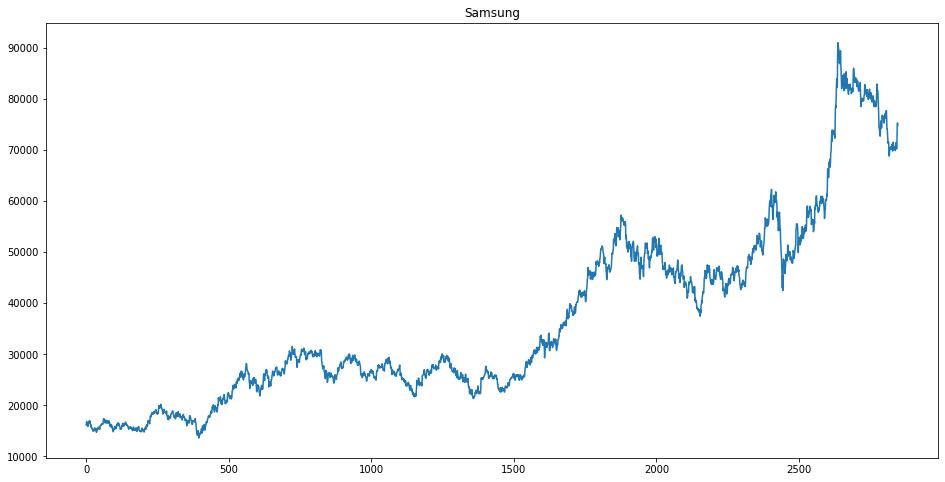

In [12]:
plt.figure(figsize=(16,8))
plt.plot(samsung_df["Close"])
plt.title("Samsung")

Text(0.5, 1.0, 'Woojung Bio')

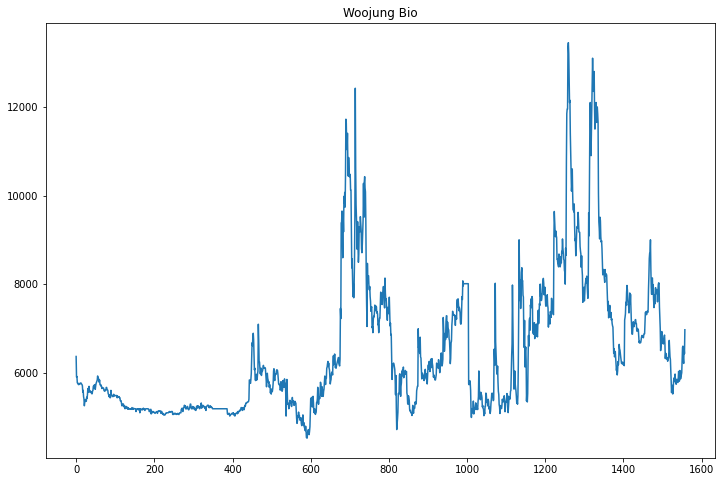

In [79]:
plt.figure(figsize=(12,8))
plt.plot(bio_df["Close"])
plt.title('Woojung Bio')

Text(0.5, 1.0, 'Access Bio')

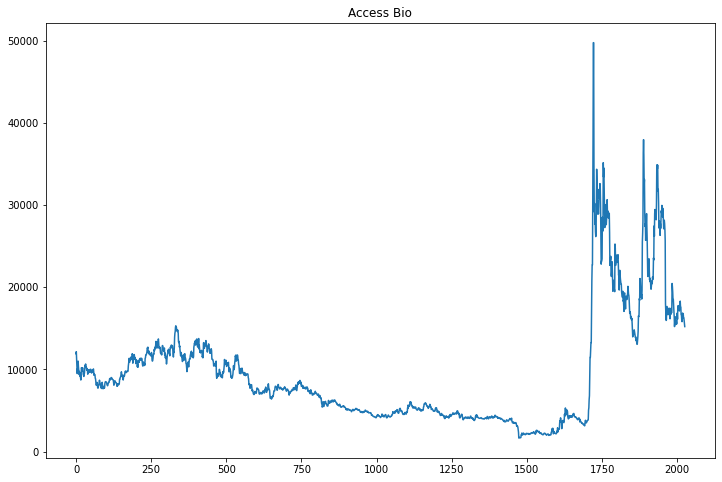

In [80]:
plt.figure(figsize=(12,8))
plt.plot(access_bio_df["Close"])
plt.title('Access Bio')

In [90]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

samsung_df_scaled = scaler.fit_transform(samsung_df[scale_cols])
bio_df_scaled = scaler.fit_transform(bio_df[scale_cols])
access_bio_df_scaled = scaler.fit_transform(access_bio_df[scale_cols])

samsung_df_scaled = pd.DataFrame(samsung_df_scaled)
samsung_df_scaled.columns = scale_cols

bio_df_scaled = pd.DataFrame(bio_df_scaled)
bio_df_scaled.columns = scale_cols

access_bio_df_scaled = pd.DataFrame(access_bio_df_scaled)
access_bio_df_scaled.columns = scale_cols

In [91]:
samsung_train = samsung_df_scaled[:-280]
samsung_test = samsung_df_scaled[-280:]

bio_train = bio_df_scaled[:-150]
bio_test = bio_df_scaled[-150:]

access_bio_train = access_bio_df_scaled[:-200]
access_bio_test = access_bio_df_scaled[-200:]

In [92]:
import numpy as np

def make_dataset(data, label, window_size):

    feature_list = []
    label_list = []

    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i : i + window_size]))
        label_list.append(np.array(label.iloc[i + window_size]))
        
    return np.array(feature_list), np.array(label_list)

In [93]:
# feature_cols = ['Open', 'High', 'Low', 'Volume']
feature_cols = ['Volume']
label_cols = ['Close']

samsung_train_feature = samsung_train[feature_cols]
samsung_train_label = samsung_train[label_cols]

samsung_test_feature = samsung_test[feature_cols]
samsung_test_label = samsung_test[label_cols]

bio_train_feature = bio_train[feature_cols]
bio_train_label = bio_train[label_cols]

bio_test_feature = bio_test[feature_cols]
bio_test_label = bio_test[label_cols]

access_bio_train_feature = access_bio_train[feature_cols]
access_bio_train_label = access_bio_train[label_cols]

access_bio_test_feature = access_bio_test[feature_cols]
access_bio_test_label = access_bio_test[label_cols]

# train dataset
samsung_train_feature, samsung_train_label = make_dataset(samsung_train_feature, samsung_train_label, 20)
bio_train_feature, bio_train_label = make_dataset(bio_train_feature, bio_train_label, 20)
access_bio_train_feature, access_bio_train_label = make_dataset(access_bio_train_feature, access_bio_train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
samsung_x_train, samsung_x_valid, samsung_y_train, samsung_y_valid = train_test_split(samsung_train_feature, samsung_train_label, test_size=0.2)
bio_x_train, bio_x_valid, bio_y_train, bio_y_valid = train_test_split(bio_train_feature, bio_train_label, test_size=0.2)
access_bio_x_train, access_bio_x_valid, access_bio_y_train, access_bio_y_valid = train_test_split(access_bio_train_feature, access_bio_train_label, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
samsung_test_feature, samsung_test_label = make_dataset(samsung_test_feature, samsung_test_label, 20)
bio_test_feature, bio_test_label = make_dataset(bio_test_feature, bio_test_label, 20)
access_bio_test_feature, access_bio_test_label = make_dataset(access_bio_test_feature, access_bio_test_label, 20)

In [94]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, input_shape=(samsung_train_feature.shape[1], samsung_train_feature.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(1))

In [95]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(samsung_x_train, samsung_y_train, epochs=20,  batch_size=8, validation_data=(samsung_x_valid, samsung_y_valid), verbose = 0)

In [96]:
model2 = Sequential()
model2.add(LSTM(16, input_shape=(bio_train_feature.shape[1], bio_train_feature.shape[2]), activation='relu', return_sequences=False))
model2.add(Dense(1))

In [97]:
model2.compile(loss='mean_squared_error', optimizer='adam')
history2 = model2.fit(bio_x_train, bio_y_train, epochs=20,  batch_size=8, validation_data=(bio_x_valid, bio_y_valid), verbose = 0)

In [98]:
model3 = Sequential()
model3.add(LSTM(16, input_shape=(access_bio_train_feature.shape[1], access_bio_train_feature.shape[2]), activation='relu', return_sequences=False))
model3.add(Dense(1))

In [99]:
model3.compile(loss='mean_squared_error', optimizer='adam')
history3 = model3.fit(access_bio_x_train, access_bio_y_train, epochs=20,  batch_size=8, validation_data=(access_bio_x_valid, access_bio_y_valid), verbose = 0)

In [100]:
samsung_pred = model.predict(samsung_test_feature)
bio_pred = model2.predict(bio_test_feature)
access_bio_pred = model3.predict(access_bio_test_feature)

In [102]:
access_bio_test

,Open,High,Low,Close,Volume
1826,0.334471,0.312401,0.428241,0.352525,0.015103
1827,0.318259,0.310016,0.420139,0.344211,0.013693
1828,0.310580,0.296502,0.396991,0.326543,0.011862
1829,0.292662,0.296502,0.396991,0.353565,0.009917
1830,0.318259,0.302067,0.418981,0.358761,0.006992
...,...,...,...,...,...
2021,0.287543,0.267886,0.373843,0.303679,0.006388
2022,0.273038,0.266296,0.368056,0.303679,0.009010
2023,0.282423,0.263911,0.369213,0.297443,0.007937
2024,0.272184,0.254372,0.358796,0.288090,0.006801


In [103]:
samsung_index_ex = list(range(2568,2568+len(samsung_pred)))
samsung_pred_df = pd.DataFrame(samsung_pred, index = samsung_index_ex)

bio_index_ex = list(range(1408,1408+len(bio_pred)))
bio_pred_df = pd.DataFrame(bio_pred, index = bio_index_ex)

access_bio_index_ex = list(range(1826,1826+len(access_bio_pred)))
access_bio_pred_df = pd.DataFrame(access_bio_pred, index = access_bio_index_ex)

In [104]:
samsung_test_df = pd.concat([samsung_test, samsung_pred_df], axis = 1)
samsung_test_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Predictions']

bio_test_df = pd.concat([bio_test, bio_pred_df], axis = 1)
bio_test_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Predictions']

access_bio_test_df = pd.concat([access_bio_test, access_bio_pred_df], axis = 1)
access_bio_test_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Predictions']

In [105]:
samsung_test_df

,Open,High,Low,Close,Volume,Predictions
2568,0.638981,0.605372,0.643575,0.571059,0.194494,0.478780
2569,0.638981,0.601240,0.644693,0.572351,0.126732,0.476290
2570,0.645626,0.607438,0.646927,0.576227,0.139681,0.485496
2571,0.645626,0.609504,0.650279,0.576227,0.171678,0.498030
2572,0.636766,0.611570,0.642458,0.582687,0.223997,0.501075
...,...,...,...,...,...,...
2843,0.782946,0.733471,0.784358,0.731266,0.112340,NaN
2844,0.779623,0.737603,0.783240,0.744186,0.132380,NaN
2845,0.811739,0.776860,0.815642,0.791990,0.304593,NaN
2846,0.841639,0.785124,0.832402,0.797158,0.243939,NaN


In [106]:
samsung_ma30_index = list(range(2588, 2588+len(samsung_test_df)))
samsung_ma30_pred_df = samsung_test_df.set_index(keys = [samsung_ma30_index], inplace = False)
samsung_ma30_pred_df

,Open,High,Low,Close,Volume,Predictions
2588,0.638981,0.605372,0.643575,0.571059,0.194494,0.478780
2589,0.638981,0.601240,0.644693,0.572351,0.126732,0.476290
2590,0.645626,0.607438,0.646927,0.576227,0.139681,0.485496
2591,0.645626,0.609504,0.650279,0.576227,0.171678,0.498030
2592,0.636766,0.611570,0.642458,0.582687,0.223997,0.501075
...,...,...,...,...,...,...
2863,0.782946,0.733471,0.784358,0.731266,0.112340,NaN
2864,0.779623,0.737603,0.783240,0.744186,0.132380,NaN
2865,0.811739,0.776860,0.815642,0.791990,0.304593,NaN
2866,0.841639,0.785124,0.832402,0.797158,0.243939,NaN


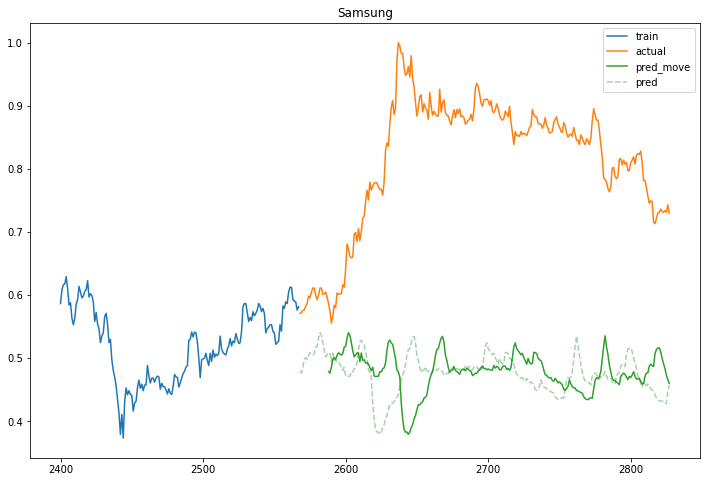

In [107]:
plt.figure(figsize=(12, 8))
plt.plot(samsung_train[2400:]['Close'], label='train')
plt.plot(samsung_test_df[:-20]['Close'], label='actual')
plt.plot(samsung_ma30_pred_df[:-40]['Predictions'], label='pred_move')
plt.plot(samsung_test_df[:-20]['Predictions'], linestyle = '--', label='pred', alpha = 0.35, c = 'green')
# plt.plot(samsung_test_df[:-20]['Predictions'], label='pred')
plt.title("Samsung")
plt.legend()
plt.show()

In [68]:
bio_test_df

,Open,High,Low,Close,Volume,Predictions
1408,0.545196,0.559459,0.594510,0.369117,0.065917,0.305378
1409,0.556584,0.541216,0.582745,0.385926,0.014975,0.303436
1410,0.567260,0.543243,0.609412,0.374720,0.008197,0.304292
1411,0.558719,0.531081,0.588235,0.350067,0.006629,0.304823
1412,0.541637,0.514865,0.581176,0.336620,0.005072,0.305602
...,...,...,...,...,...,...
1553,0.473310,0.451351,0.494118,0.199910,0.003471,NaN
1554,0.449110,0.437162,0.481569,0.188705,0.002816,NaN
1555,0.448399,0.447297,0.494118,0.227925,0.007580,NaN
1556,0.466904,0.445946,0.498039,0.213357,0.002775,NaN


In [108]:
ma30_index = list(range(1428,1428+len(bio_test_df)))
ma30_bio_pred_df = bio_test_df.set_index(keys = [ma30_index], inplace = False)
ma30_bio_pred_df

,Open,High,Low,Close,Volume,Predictions
1428,0.545196,0.559459,0.594510,0.369117,0.065917,0.189044
1429,0.556584,0.541216,0.582745,0.385926,0.014975,0.173110
1430,0.567260,0.543243,0.609412,0.374720,0.008197,0.167283
1431,0.558719,0.531081,0.588235,0.350067,0.006629,0.163212
1432,0.541637,0.514865,0.581176,0.336620,0.005072,0.159243
...,...,...,...,...,...,...
1573,0.473310,0.451351,0.494118,0.199910,0.003471,NaN
1574,0.449110,0.437162,0.481569,0.188705,0.002816,NaN
1575,0.448399,0.447297,0.494118,0.227925,0.007580,NaN
1576,0.466904,0.445946,0.498039,0.213357,0.002775,NaN


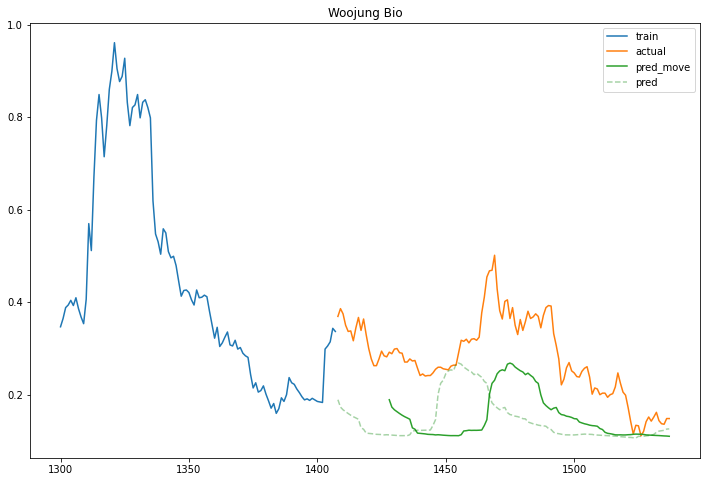

In [116]:
plt.figure(figsize=(12, 8))
plt.plot(bio_train[1300:]['Close'], label='train')
plt.plot(bio_test_df[:-20]['Close'], label='actual')
plt.plot(ma30_bio_pred_df[:-40]['Predictions'], label='pred_move')
plt.plot(bio_test_df[:-20]['Predictions'], linestyle = '--', label='pred', alpha = 0.35, c = 'green')
# plt.plot(bio_test_df[:-20]['Predictions'], label='pred')
plt.title("Woojung Bio")
plt.legend()
plt.show()

In [70]:
access_bio_test_df

,Open,High,Low,Close,Volume,Predictions
1826,0.334471,0.312401,0.428241,0.352525,0.015103,0.330067
1827,0.318259,0.310016,0.420139,0.344211,0.013693,0.325543
1828,0.310580,0.296502,0.396991,0.326543,0.011862,0.323066
1829,0.292662,0.296502,0.396991,0.353565,0.009917,0.317237
1830,0.318259,0.302067,0.418981,0.358761,0.006992,0.315698
...,...,...,...,...,...,...
2021,0.287543,0.267886,0.373843,0.303679,0.006388,NaN
2022,0.273038,0.266296,0.368056,0.303679,0.009010,NaN
2023,0.282423,0.263911,0.369213,0.297443,0.007937,NaN
2024,0.272184,0.254372,0.358796,0.288090,0.006801,NaN


In [112]:
access_bio_ma30_index = list(range(1846,1846+len(access_bio_test_df)))
access_bio_ma30_pred_df = access_bio_test_df.set_index(keys = [access_bio_ma30_index], inplace = False)
access_bio_ma30_pred_df

,Open,High,Low,Close,Volume,Predictions
1846,0.334471,0.312401,0.428241,0.352525,0.015103,0.150927
1847,0.318259,0.310016,0.420139,0.344211,0.013693,0.150927
1848,0.310580,0.296502,0.396991,0.326543,0.011862,0.149732
1849,0.292662,0.296502,0.396991,0.353565,0.009917,0.148456
1850,0.318259,0.302067,0.418981,0.358761,0.006992,0.147271
...,...,...,...,...,...,...
2041,0.287543,0.267886,0.373843,0.303679,0.006388,NaN
2042,0.273038,0.266296,0.368056,0.303679,0.009010,NaN
2043,0.282423,0.263911,0.369213,0.297443,0.007937,NaN
2044,0.272184,0.254372,0.358796,0.288090,0.006801,NaN


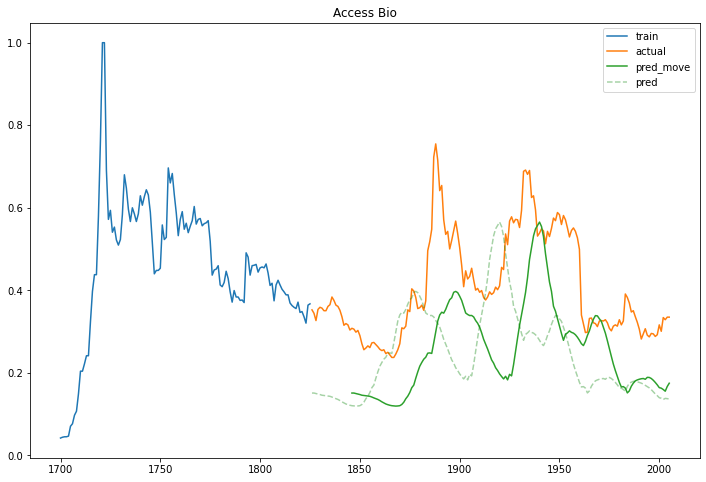

In [114]:
plt.figure(figsize=(12, 8))
plt.plot(access_bio_train[1700:]['Close'], label='train')
plt.plot(access_bio_test_df[:-20]['Close'], label='actual')
plt.plot(access_bio_ma30_pred_df[:-40]['Predictions'], label='pred_move')
plt.plot(access_bio_test_df[:-20]['Predictions'], linestyle = '--', label='pred', alpha = 0.35, c = 'green')
# plt.plot(access_bio_test_df[:-20]['Predictions'], label='pred')
plt.title("Access Bio")
plt.legend()
plt.show()